In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
import datetime
from typing import List, Callable
import itertools
import datetime
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import npd_entropy
from sidpy import *


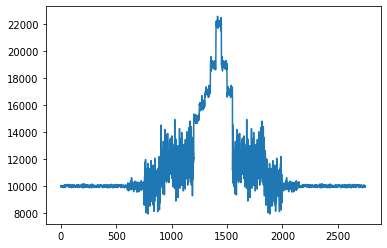

In [18]:
# np.random.normal(mean, std, size)
samples_1_1 = np.random.normal(10000, 50, size=600).tolist()
samples_1_2 = np.random.normal(10000, 200, size=150).tolist()
samples_1_3 = np.random.normal(10000, 1000, size=150).tolist()
samples_1_4 = np.random.normal(12000, 1100, size=300).tolist()
samples_1_5 = np.random.normal(15000, 200, size=50).tolist()
samples_1_6 = np.random.normal(16000, 200, size=50).tolist()
samples_1_7 = np.random.normal(17000, 200, size=50).tolist()
samples_1_8 = np.random.normal(19000, 200, size=50).tolist()
samples_1_9 = np.random.normal(22000, 200, size=50).tolist()
base_1=samples_1_1+samples_1_2+samples_1_3+samples_1_4+samples_1_5+samples_1_6+samples_1_7+samples_1_8+samples_1_9+samples_1_8+samples_1_7+samples_1_4+samples_1_3+samples_1_2+samples_1_1

plt.plot(base_1)
plt.show()

In [22]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

In [26]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [20]:
def fuzzy_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_fuzzy(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [21]:
def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [35]:
sampen_1 = sampen_loop(base_1,100)

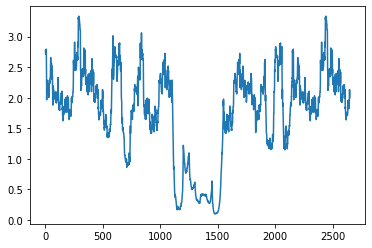

In [36]:
plt.plot(sampen_1)

In [37]:
fuzzy_1 = fuzzy_loop(base_1,100)

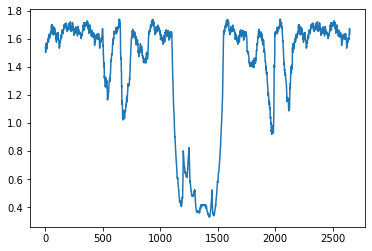

In [38]:
plt.plot(fuzzy_1)

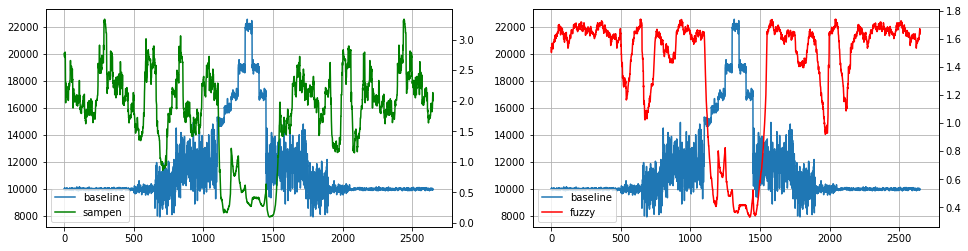

In [40]:
x2_fig, x2_axes = plt.subplots(1, 2, figsize=(16, 4))
x2_ln1 = x2_axes[0].plot(base_1[100:],label='baseline')

x2_ax1 = x2_axes[0].twinx()
x2_ln2 = x2_ax1.plot(sampen_1, color='green', label="sampen")

x2_h1, x2_l1 = x2_axes[0].get_legend_handles_labels()
x2_h2, x2_l2 = x2_ax1.get_legend_handles_labels()
x2_axes[0].legend(x2_h1+x2_h2, x2_l1+x2_l2, loc='lower left')

x2_axes[0].grid(True)

x2_rn1 = x2_axes[1].plot(base_1[100:],label='baseline')

x2_ax2 = x2_axes[1].twinx()
x2_rn2 = x2_ax2.plot(fuzzy_1, color='red', label="fuzzy")

x2_h3, x2_l3 = x2_axes[1].get_legend_handles_labels()
x2_h4, x2_l4 = x2_ax2.get_legend_handles_labels()
x2_axes[1].legend(x2_h3+x2_h4, x2_l3+x2_l4, loc='lower left')

x2_axes[1].grid(True)



In [49]:
nk.entropy_fuzzy(np.random.normal(0, 1, size=100))

(1.7158786407126028,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.22670989494538096})